# Benchmark: PXD024043 - Proteins

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the protein dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pg_matrix.tsv".

Let's start with the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from scp.models import PROTVI
import scp.plots as pl
import scp.utils as utils
import scp.benchmark_models as bm

import scvi

np.random.seed(42)
scvi.settings.seed = 42

Global seed set to 42


Let's define the path to the data.

In [2]:
DATA_PATH = "../../../data/PXD024043/20210919_DIANN_SingleCellOutput.pg_matrix.tsv"

## Data loading

Let's load the data

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")

In [4]:
var_cols = [c for c in data.columns if "D:\\" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = [filename.split("\\")[-1] for filename in data.index.copy()]
data.index = obs_names

In [5]:
obs_new = [obs.replace("-", "_").replace("SA_ADB", "SA-ADB") for obs in obs_names]
annotations = [obs.split("_") for obs in obs_new]

dates = [obs[0] for obs in annotations]
unknown1 = [obs[3] for obs in annotations]
n_cells = [obs[4] for obs in annotations]
species = [obs[5] for obs in annotations]
unknown2 = [obs[6] for obs in annotations]
unknown3 = [obs[7] for obs in annotations]
unknown4 = [obs[8] for obs in annotations]
position = [obs[9] for obs in annotations]
replicate = [obs[10] for obs in annotations]
file_index = [obs[11][:-2] for obs in annotations]

condition = [
    "G1" if "G1" in unk2
    else "G1-S" if "TB" == unk2
    else "G2" if "G2" == unk2
    else "G1-M" if "NB" == unk2
    else "UB_Passage01" if ("UB" == unk2) and ("20201010" == date)
    else "UB_Passage02_Plate01" if ("UB" == unk2) and (int(file_index) < 5050)
    else "UB_Passage02_Plate02"
    for unk2, file_index, date in zip(unknown2, file_index, dates)
]

cell_cycle_stage = [
    "G1" if "G1" == name
    else "G1-S" if "TB" == name
    else "G2" if "G2" == name
    else "G2-M" if "NB" == name
    else "other"
    for name in unknown2
]

coarse_condition = ["UB" if "UB" in c else "G" for c in condition]

In [6]:
obs = pd.DataFrame(
    {
        "date": dates,
        "unknown1": unknown1,
        "n_cells": n_cells,
        "species": species,
        "unknown2": unknown2,
        "unknown3": unknown3,
        "unknown4": unknown4,
        "position": position,
        "replicate": replicate,
        "file_index": file_index,
        "condition": condition,
        "coarse_condition": coarse_condition,
        "cell_cycle_stage": cell_cycle_stage,
    },

    index=obs_names,
)

adata = sc.AnnData(X=data, var=vars, obs=obs)

adata.X[adata.X == 0] = np.NaN
adata.layers["raw"] = adata.X.copy()

In [7]:
adata

AnnData object with n_obs × n_vars = 434 × 2501
    obs: 'date', 'unknown1', 'n_cells', 'species', 'unknown2', 'unknown3', 'unknown4', 'position', 'replicate', 'file_index', 'condition', 'coarse_condition', 'cell_cycle_stage'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description'
    layers: 'raw'

In [8]:
adata = utils.sort_anndata_by_missingness(adata)

Filter proteins.

In [9]:
#peptides = np.random.choice(adata.shape[1], size=400, replace=False)
#adata = adata[:, peptides].copy()

In [10]:
print(f"nan intensities: {np.isnan(adata.layers['raw']).sum() / (adata.shape[0] * adata.shape[1]) * 100:.2f}%")

nan intensities: 48.24%


## Data Exploration

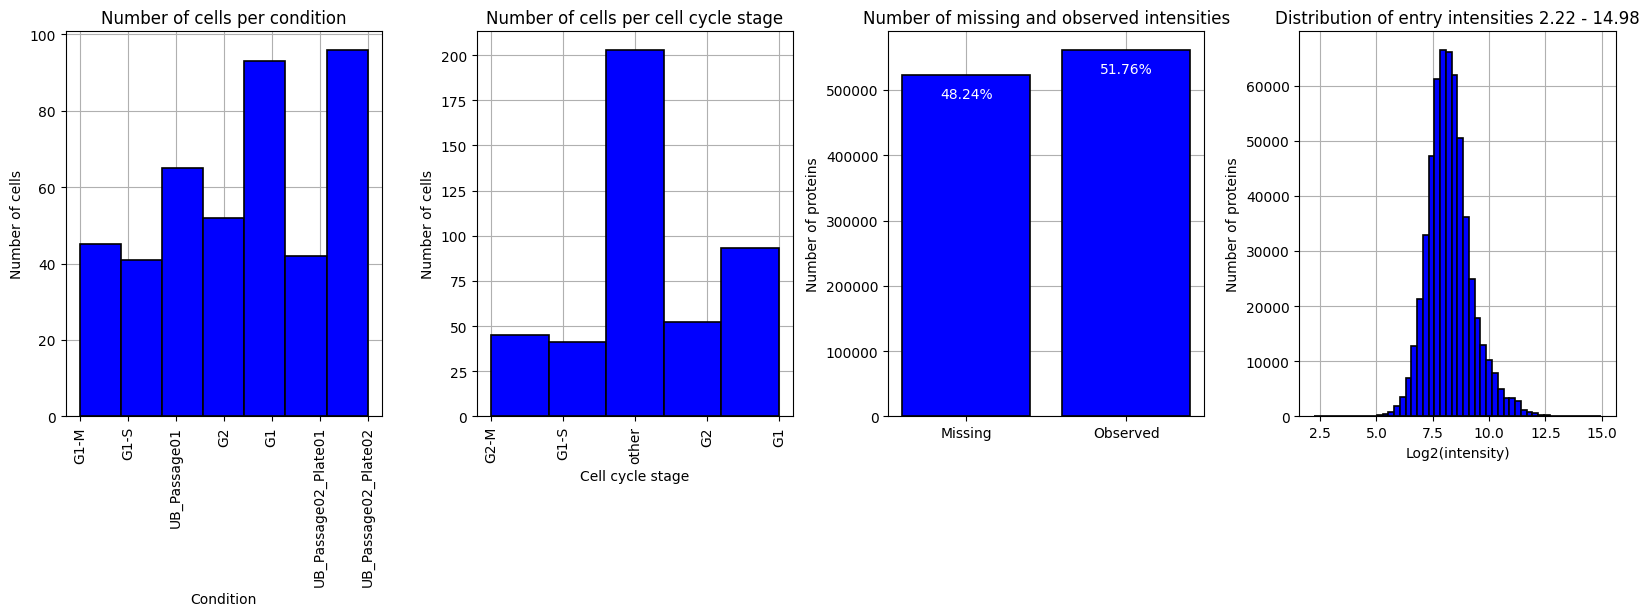

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.subplots_adjust(wspace=0.3)

x = adata.layers["raw"]

ax = axes[0]
ax.hist(adata.obs["condition"], bins=len(adata.obs["condition"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_title("Number of cells per condition")
ax.set_xlabel("Condition")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axes[1]
ax.hist(adata.obs["cell_cycle_stage"], bins=len(adata.obs["cell_cycle_stage"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_title("Number of cells per cell cycle stage")
ax.set_xlabel("Cell cycle stage")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axes[2]
n_miss = np.isnan(x).sum()
n_obs = (~np.isnan(x)).sum()
n_total = n_miss + n_obs
ax.bar(["Missing", "Observed"], [n_miss, n_obs], color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_title("Number of missing and observed intensities")
ax.grid(True)
ax.set_axisbelow(True)

for rect in ax.patches:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height - 40_000, f"{height / n_total* 100:.2f}%", ha="center", va="bottom", color="white")

# plot intensity distribution
ax = axes[3]
x = x[~np.isnan(x)].flatten()

ax.hist(x, bins=50, color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Log2(intensity)")
ax.set_ylabel("Number of proteins")
ax.set_title(f"Distribution of entry intensities {np.min(x):.2f} - {np.max(x):.2f}")
ax.grid(True)
ax.set_axisbelow(True)

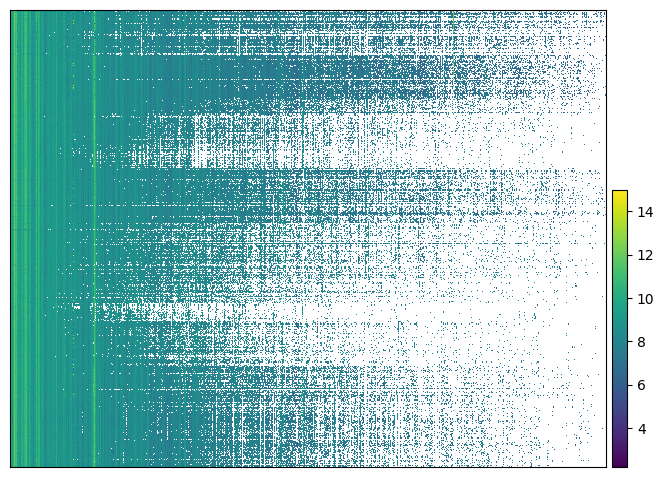

In [12]:
sc.pl.heatmap(adata, var_names=adata.var_names, groupby="species", show_gene_labels=False)

In [27]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="raw")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 5.76%


Let's see if we can decide which annotation is the batch effect.

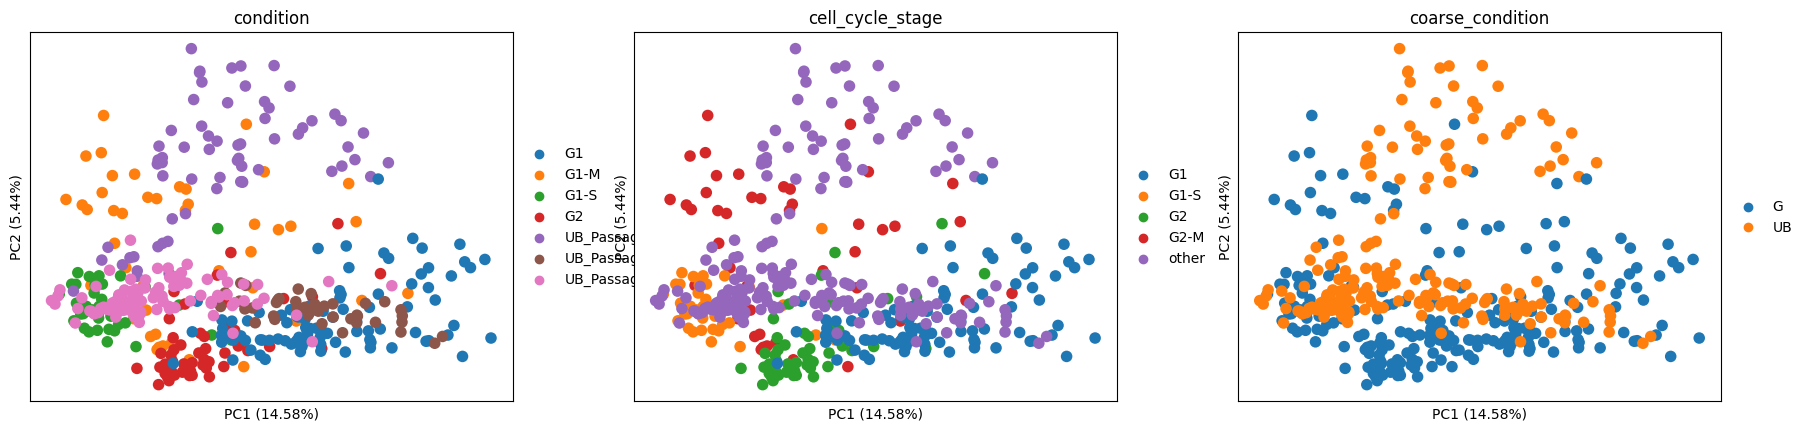

In [13]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
    components=["1,2"],
)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
)

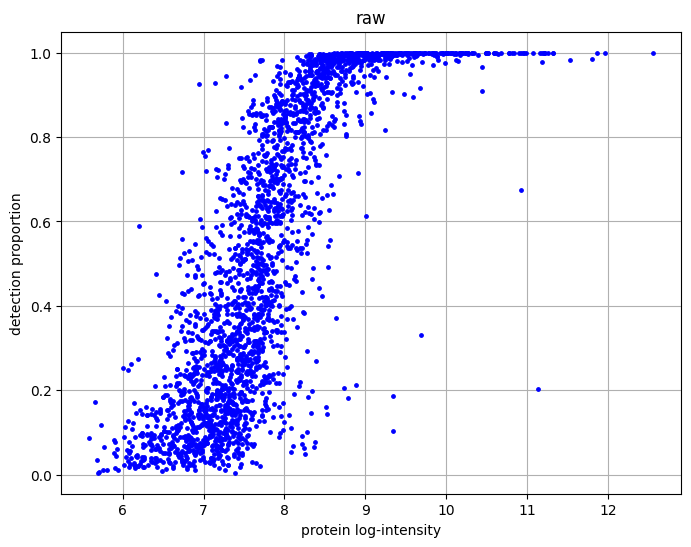

In [14]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="raw")